# ДЗ 3. A/B-тестирование, ранговые критерии, бутстрэп

Дедлайн: 19.12.2023 в 23:59

Вот и наступило время решать заключительное ДЗ в рамках курса ПСМО! Что вам нужно будет сделать (вкратце):

- Всё дз в рамках одного набора данных о рекламной платформе
- Сначала необходимо выбрать правильное сплитование данных из 3 предложенных, на основании значения которой будет происходить A/B тест. Обосновать выбор, проверив необходимые предпосылки однородности А и В выборок с помощью ранговых критериев и изученного статистического аппарата (2 балла)
- * Может приключиться такая ситуация, что выбранное сплитование не совсем подходит для проведения A/B, поэтому не поленитесь выбрать ту, для которой интерпретация каждого из ранговых критериев соответствует вашим исходным предположениям
- Провести A/B тест и подвести итоги со всеми статистиками, использовать техники с семинара для повышения чувствительности/корректности А/В теста (3.5 балла)
- Реализовать бутстрап как альтернативный метод проверки гипотеы, поставленной в А/В (3 балла)
- Содержательные выводы по итогам работы, интерпретирующие результат с бизнесовой точки зрения, как минимум 3-4 предложения (1.5 балла)

Бонусы!
- +1 балл к дз, если до проведения основной части работы вы реализуете ЕМ-алгоритм для разделения смеси распределений (подсказка: смесей от 2 до 4)
- +1 балл к дз, если реализуете CUPED в рамках анализа результатов А/В

P.s. Кажется, если вы хорошо поняли крайние 3 темы курса, на решение ДЗ и интерпретацию результатов у вас уйдёт не больше 3-4 часов. Это дз больше про понимание и умение интерпретировать полученное, а не про фундаментальную математику

### Мотивация: 

Принесёт ли изменение модели машинного обучения (логрег заменим на catboost) в сервисе ранжирования рекламных объявлений бОльшую конверсию просмотров объявления в клик?

Считаем, что увеличение CTR будет свидетельством того, что мы получили большую конверсию в клик.

In [5]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
from scipy import stats

Что есть в датасете для выполнения домашки:
* id - идентификатор пользователя
* split_1 - вариант сплитования 1
* split_2 - вариант сплитования 2
* split_3 - вариант сплитования 3
* is_teenager - меньше ли 25 лет пользователю
* num_segments - количество сегментов интересов [футбол, баскетбол, киберспорт, etc.] у пользователя
* views - просмотры рекламы в рамках проведённого эксперимента
* clicks - клики по рекламе в рамках проведённого эксперимента
* CTR - views / clicks

In [6]:
data = pd.read_csv('https://raw.githubusercontent.com/ZolotarevStat/psmo_22_23/2023/df_hw3.csv')
data

,id,split_1,split_2,split_3,is_teenager,num_segments,views,clicks,ctr
0,0,A,B,A,0,15,62,3,0.048387
1,1,A,B,B,0,4,5,0,0.000000
2,2,B,A,B,1,14,47,1,0.021277
3,3,B,A,B,1,2,3,0,0.000000
4,4,B,A,B,0,11,50,0,0.000000
...,...,...,...,...,...,...,...,...,...
19995,19995,B,A,A,1,4,5,0,0.000000
19996,19996,B,A,B,1,2,7,0,0.000000
19997,19997,A,B,A,0,6,22,5,0.227273
19998,19998,A,A,B,0,10,52,0,0.000000


## Бонус: EM (1 балл)

Реализуйте ЕМ-алгоритм для разделения смеси распределений (подсказка: смесей от 2 до 4) исходных данных. Реализация поможет лучше интерпретировать полученные результаты по ходу всего ДЗ


Посмотрим на распределения признаков:

<Axes: xlabel='num_segments', ylabel='Density'>

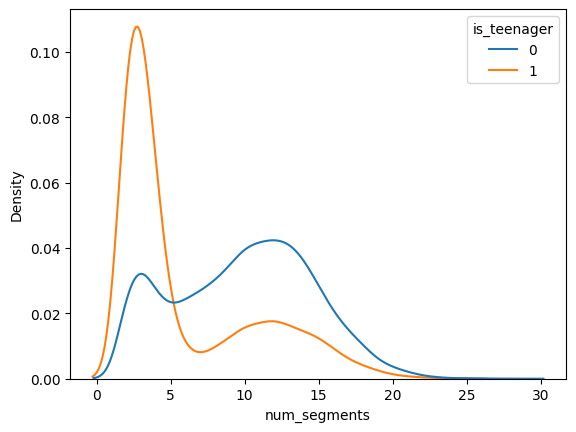

In [7]:
sns.kdeplot(data, x='num_segments', hue='is_teenager')

Пусть у нас K компонент в смеси и $n$ элементов в выборке. Пусть $\xi \in \mathbb{R}^{n \times 2}$ выборка, где $\xi_{i, 1}$ - соответствия тинейджеру i-го наболюдения, $\xi_{i, 2}$ - кол-во сегментов, при этом они независимы и получаются из суммы многомерных распределений, где одна из компонент - бернуллиевская с.в. с параметром $p_j$, а другая - пуассоновская с параметром $\lambda_j$. Пусть $Z_i$ - скрытая случайная величина, которая говорит, из какой из компонент смеси мы семплируем $\xi_i$.

Иными словами,

$$P(\xi_{i, 1} = A, \xi_{i, 2} = B) = \sum_{i=1}^{K}q_ip_i^{A}(1 - p_i)^{1 - A}\left( \frac{e^{-\lambda_i}\lambda_i^B}{B!} \right), \sum_{i=1}^Kq_i = 1$$

Нижняя оценка на лог-правдоподобие:

$$Q(\hat{\theta}, \theta) = \sum_{i=1}^{n} \sum_{j=1}^{K}w_i^{(j)}\ln \left[  \frac{q_j}{w_i^{(j)}}p^{\xi_{i, 1}}(1 - p)^{1 - \xi_{i, 1}} \frac{e^{-\lambda_j}\lambda_j^{\xi_{i, 2}}}{\xi_{i, 2}!} \right]$$

Запишем явно Е, М шаги алгоритма (всё делается аналогично домашке по ЕМ-алгоритму, так что в целях чистоты домашки опустим вычисления):

E - шаг:

$$ w_i^{(j)} =  P(Z_i = k | X_i) = \frac{P(Z_i = k)P(X_i = \hat{X_i} | Z_i = k)}{P(X_i = \hat{X_i})}$$

M - шаг:

$$\begin{cases}
q_j = \frac{\sum_{i=1}^n w_i^{(j)}}{n} \\
p_j = \frac{\sum_{i=1}^n w_i^{(j)}\xi_{i, 1}}{\sum_{i=1}^n w_i^{(j)}} \\
\lambda_j = \frac{\sum_{i=1}^n w_i^{(j)}\xi_{i, 2}}{\sum_{i=1}^n w_i^{(j)}} \\
\end{cases}$$

In [10]:
class UsersMixtureModel:
    '''
    Implements EM algorithm for clusterizing users
    '''

    def __init__(self, K=1, ps=[0], lambdas=[1], qs=[1]):
        '''
        Input
        int K -- number of components
        list(float[] np.array(d)) mus -- K entries of (d,), expected values
        list(float[][]) sigmas -- K entries of (d,d,), covariances
        list(float) qs -- K floats, weights, positive and sump up to 1
        '''
        self.K=K
        self.ps = ps
        self.lambdas = lambdas
        self.qs = qs
        self.w = None


    def sample(self, N=10):
        '''
        Samples N samples from the model
        Input
        int N -- number of samples
        Output
        float[][] -- (N,d), N d-dimensional samples
        int[] -- (N,), cluster assignments
        '''
        bins = stats.multinomial.rvs(1, self.qs, N).argmax(axis=1)
        samples = np.ndarray((N, 2))
        for i in range(N):
            samples[i, 0] = stats.bernoulli.rvs(self.ps[bins[i]])
            samples[i, 1] = stats.poisson.rvs(self.lambdas[bins[i]])
        return samples, bins
        pass
        #YOUR CODE

    def pdf(self, data):
      return np.array(self.qs).T @\
       (np.array([stats.poisson.pmf(data[:, 1], self.lambdas[i]) for i in range(self.K)]) \
        * np.array([stats.bernoulli.pmf(data[:, 0], self.ps[i]) for i in range(self.K)]))

    def log_likelihood(self, data):
      return np.sum(np.log(self.pdf(data)))

    def fitEM(self, data, nSteps):
        N = data.shape[0]
        '''
        Fits mus and sigmas using EM-algorithm
        Input
        float[][] data -- (batch, d), given data
        int nSteps --  number of steps for EM
        '''
        cur_q = self.log_likelihood(data)
        q_history = [cur_q]
        w = None
        for _ in range(nSteps):
            w = np.ndarray((self.K, ))
            w = np.array(self.qs).reshape((self.K, 1)) * (np.array([stats.poisson.pmf(data[:, 1], self.lambdas[i]) for i in range(self.K)]) * np.array([stats.bernoulli.pmf(data[:, 0], self.ps[i]) for i in range(self.K)]))
            w /= np.sum(w, axis=0)
            w = w.T

            self.qs = w.sum(axis=0) / N

            for i, w_sum in enumerate(w.sum(axis=0)):
                self.ps[i] = (w[:, i] @ data[:, 0]) / w_sum
                self.lambdas[i] = (w[:, i] @ data[:, 1]) / w_sum
            cur_q = self.log_likelihood(data)
            q_history.append(cur_q)
        return q_history, w.argmax(axis=1)
        pass

Переберём кол-во кластеров и посмотрим на гистограммы распределений:

[0.7326112620505043, 0.26374307989556567] [3.335583232610722, 12.013738756319384] [0.46059197 0.53940803]
[0.9963785414125788, 0.5107247284845073, 0.2667823583046254] [3.061026840770174, 3.633592250907858, 12.080771486083043] [0.20368324 0.26363247 0.5326843 ]
[0.9986054389371675, 0.9978714693256528, 0.014137259239692935, 0.27641057629514554] [3.147998870701457, 3.148339096193939, 4.278986318739787, 12.215224365212327] [0.10315734 0.23174171 0.14642303 0.51867792]


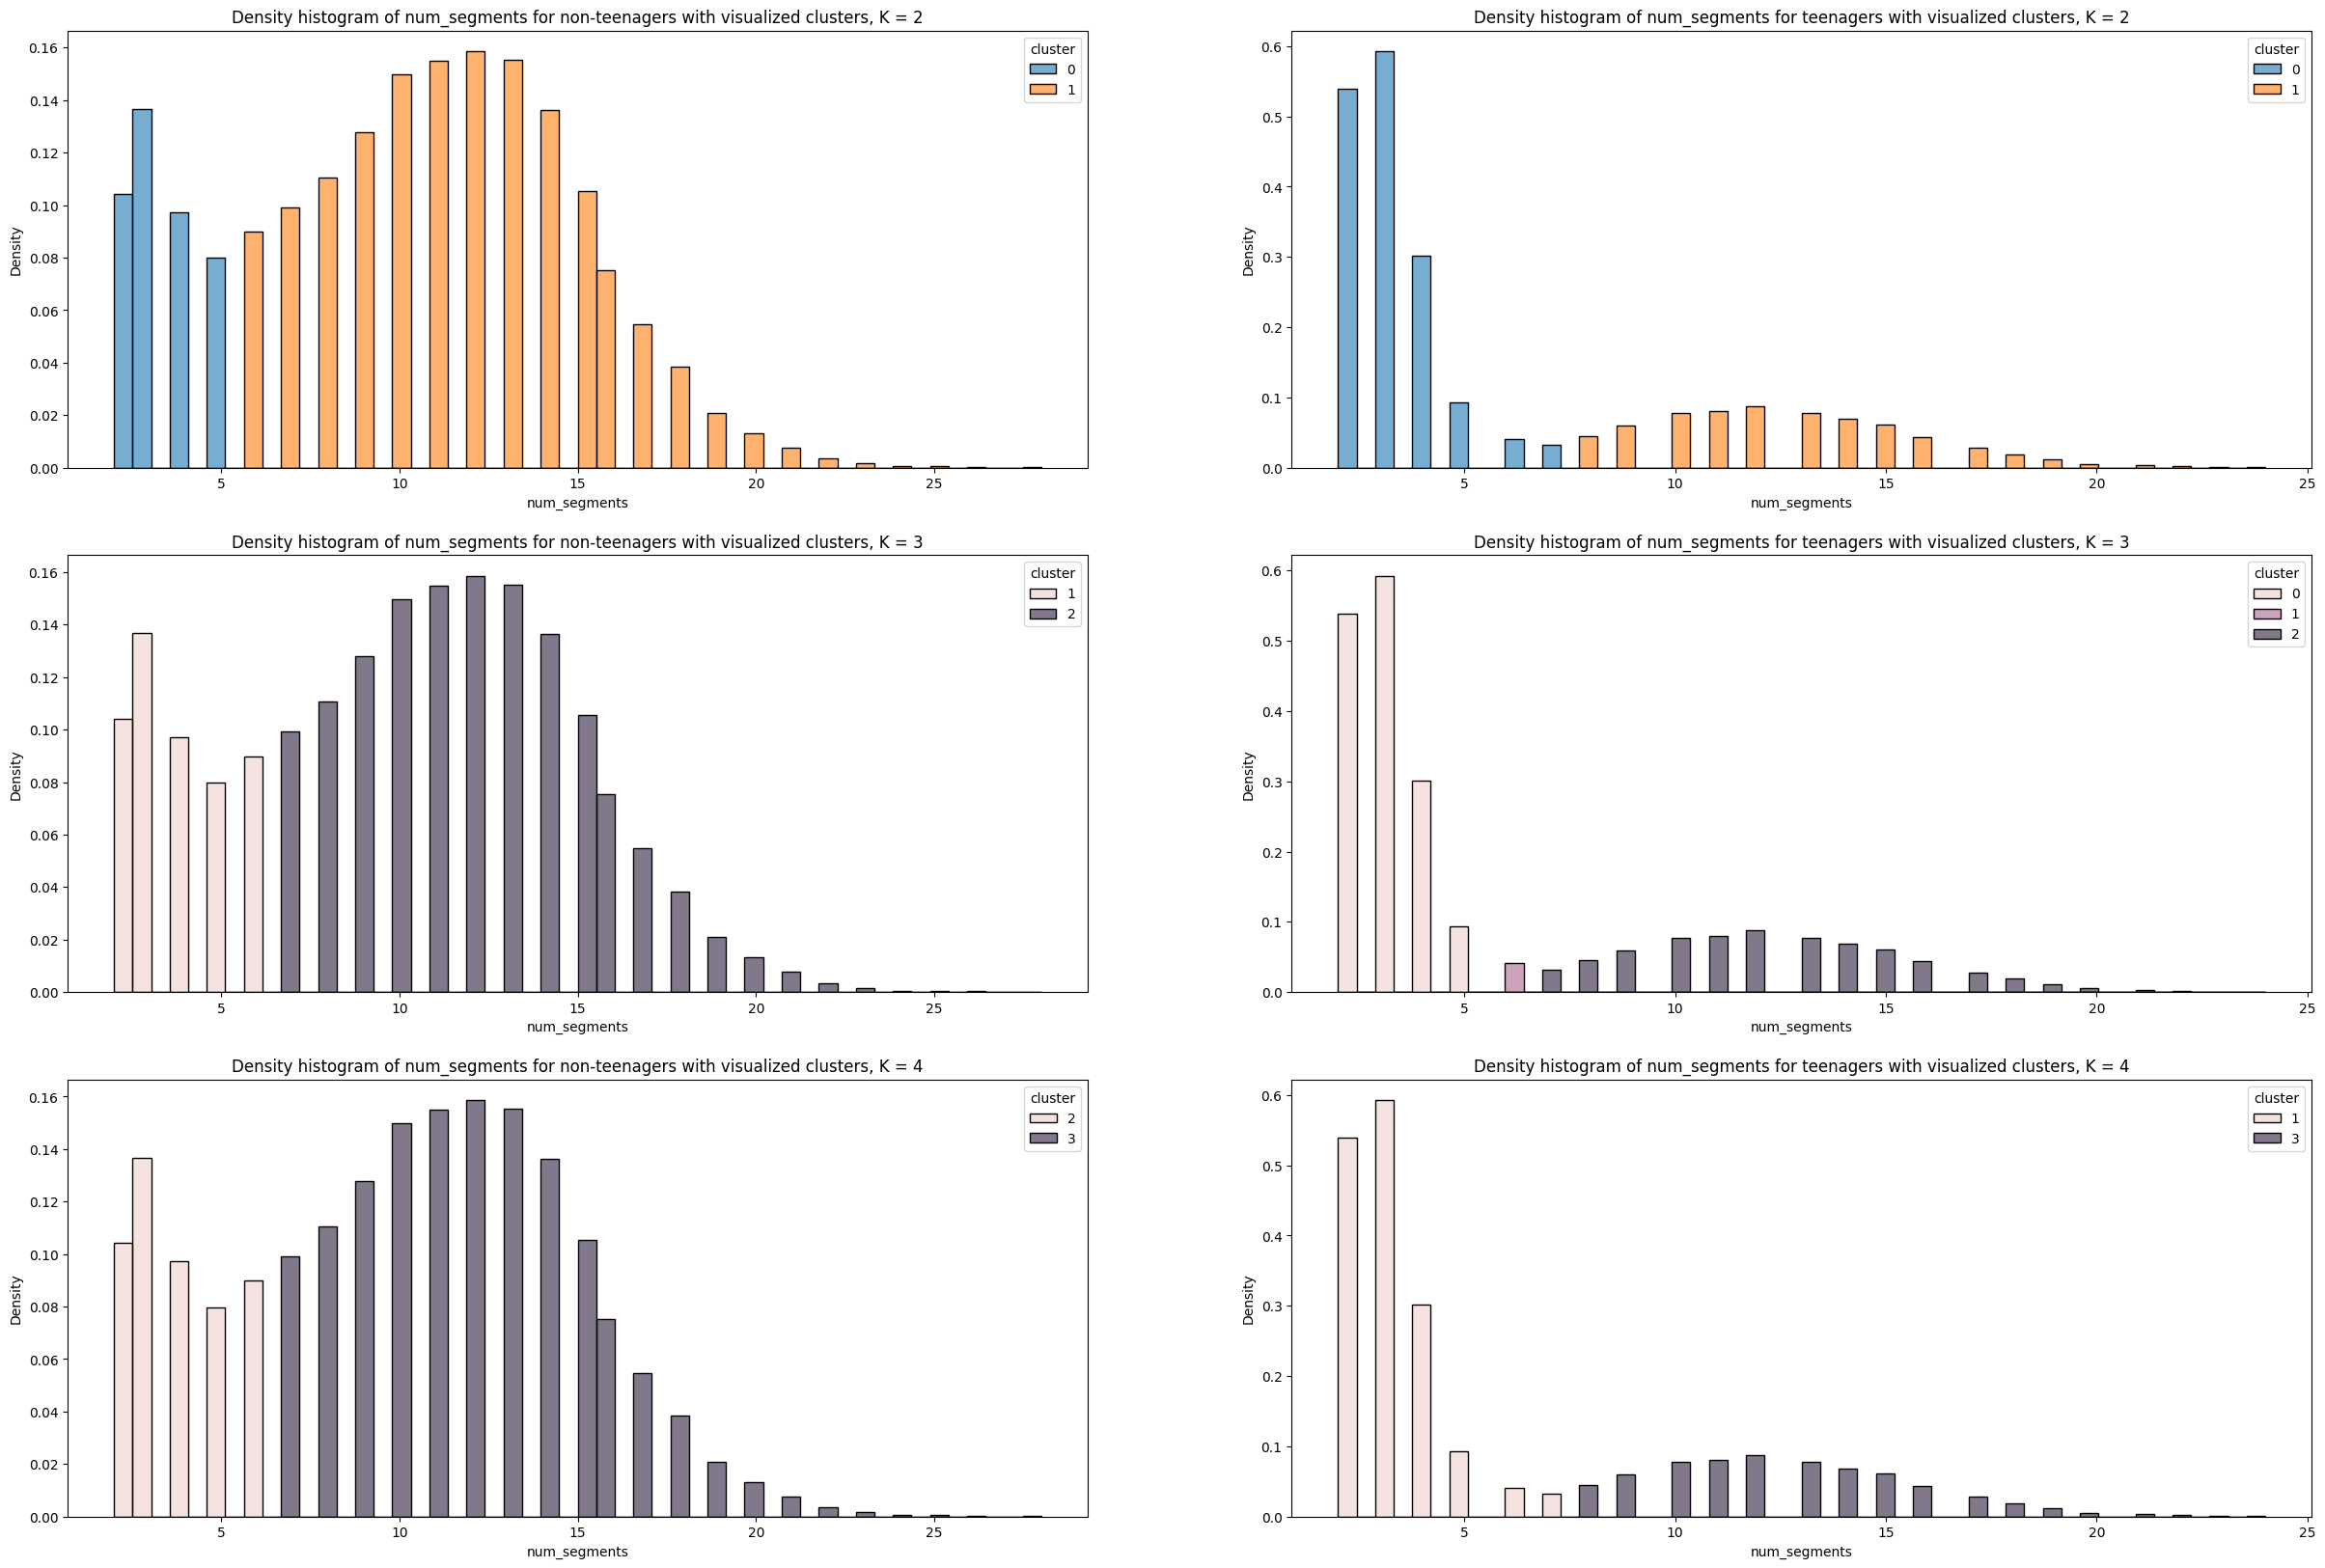

In [27]:
fig, ax = plt.subplots(3, 2, figsize=(30, 20))
for i in range(2, 5):
    model_clients = UsersMixtureModel(i, ps=[1 / i for _ in range(i)], lambdas=[2 ** j for j in range(i)], qs=[1/i for _ in range(i)] ) #инициализация с потолочными параметрами
    q_clients_history, data_clusters = model_clients.fitEM(data[['is_teenager', 'num_segments']].values, 100)
    data['cluster'] = data_clusters
    sns.histplot(data[data['is_teenager'] == 0], stat="density", x='num_segments', hue='cluster', ax=ax[i - 2, 0], bins=50, alpha=0.6)
    ax[i - 2, 0].set_title(f"Density histogram of num_segments for non-teenagers with visualized clusters, K = {i}")
    sns.histplot(data[data['is_teenager'] == 1], stat="density", x='num_segments', hue='cluster', ax=ax[i - 2, 1], bins=50, alpha=0.6)
    ax[i - 2, 1].set_title(f"Density histogram of num_segments for teenagers with visualized clusters, K = {i}")
data = data.drop(columns='cluster')
plt.show()

Уже визуально видно, что лучше всего выглядят 2 кластера в нашей модели.

Значит, у нас есть два вида пользователей, который отличаются качественно кол-вом сегментов

## Проверяем однородность разбиений (2 балла)

В этой части задания необходимо выбрать правильный метод разбиения выборки из предложенных вариантов [split_1, split_2, split_3], проверяя следующие гипотезы [при проверке используйте как минимум 2 ранговых критерия]:
* гипотеза о сдвиге
* гипотеза о масштабе
* гипотеза о независимости

Однородность разбиений необходимо проверять, используя только те данные, которые есть у нас ДО проведения А/В теста.

Разбалловка:
* За реализацию кода +0.5 балла
* За корректный и *обоснованный* выбор признаков, на основе которых проверяется однородность, +0.5 балла (при неверном выборе признаков 0 баллов за последующие части этого блока)
* За интерпретацию полученных результатов проверки гипотез +0.5 балла
* За выбор правильного метода разбиения по итогам блока +0.5 балла

NOTE: Обратите внимание на формат данных, имеющихся о пользователе до проведения эксперимента И внимательно подумайте над тем, каким образом можно проверить гипотезу о независимости

Т.к. мы делаем эксперимент и смотрим на CTR, то, очевидно, данные по кликам и показам нам недоступна до проведения эксперимента. Получается, что нам важно проверить то, что наши разбиения корректны по признакам is_teenager и num_segments (это все данные, которые у нас есть, а id - это уникальный признак для каждого из объектов)

Заметим, что is_teenager - биноминальная случайная величина, так что для неё имеет смысл проверить только гипотезу о независимости принадлежности к группе тинейджеров (которая проверяется через критерий хи-квадрат Пирсона), а вот num_segments - какая-то произвольная дискретная величина, которую справедливо проверять на однородность через гипотезу о сдвиге/масштабе

Построим графики распределений имеющихся у нас до эксперимента признаков в разрезе способа сплитования:

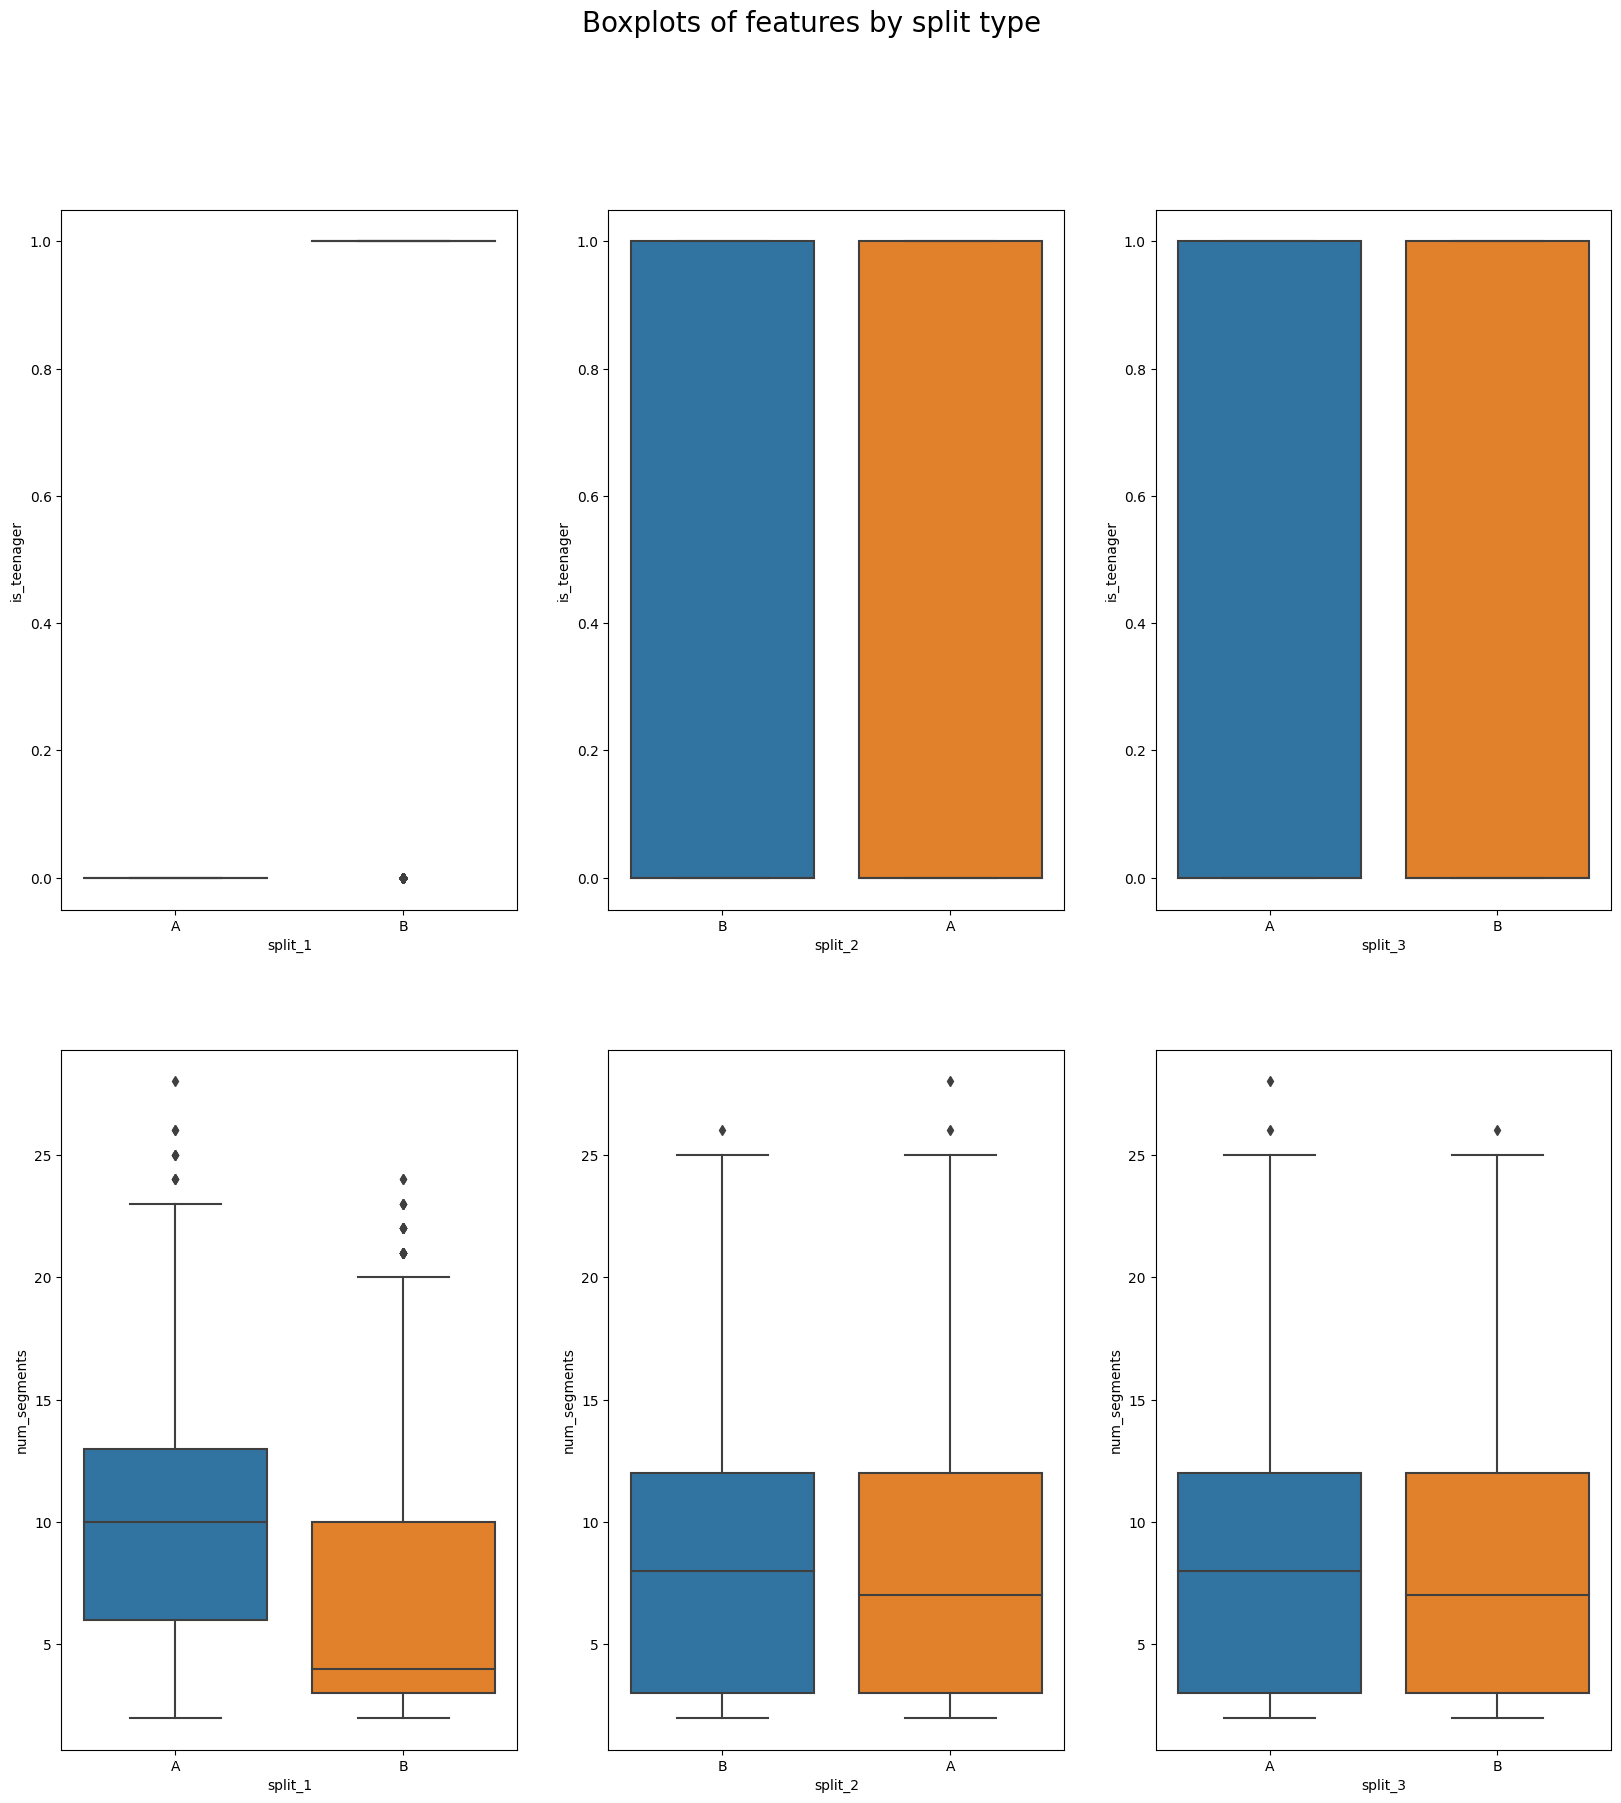

In [29]:
splits = ['split_1', 'split_2', 'split_3']

fig, ax = plt.subplots(2, 3, figsize=(20, 20))
fig.suptitle("Boxplots of features by split type", fontsize=20)

for i, split in enumerate(splits):
    sns.boxplot(data, x=split, y='is_teenager', ax=ax[0, i])
    sns.boxplot(data, x=split, y='num_segments', ax=ax[1, i])
plt.show()

Уже визуально видим разницы в распределениях для первого способа разделения на тест и контроль. Очевидно, что A/A тест для первого способа сплитования не пройдёт, но все равно проведём проверку гипотез об однородности выборок для всех способов сплитования.

Проведём множественное тестирование, и если есть способ сплитования, при котором мы принимаем все гипотезы, то это - самый лучший способ сплитования

In [30]:
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats

In [31]:
verbose = True

for i, split in enumerate(splits):
    control = data[data[split] == 'A']
    test = data[data[split] == 'B']
    contigency_table = pd.crosstab(index=data[split], columns=data['is_teenager'])
    results_is_teenager_ind = stats.chi2_contingency(contigency_table \
                                                     .dropna(axis=1))
    results_scale = stats.ansari(control.num_segments,
                                 test.num_segments)
    results_bias = stats.mannwhitneyu(control.num_segments,
                                      control.num_segments)
    overall_pvalue = multipletests([results_is_teenager_ind.pvalue,
                                    results_scale.pvalue,
                                    results_bias.pvalue], alpha=0.05,
                                   method='holm')
    if verbose:
        print(f"Statistic for is_teenager independence test: ' \
              '{results_is_teenager_ind.statistic}, p-value: {results_is_teenager_ind.pvalue}")
        print(f"Statistic for is num_segnemts scale test: ' \
              '{results_scale.statistic}, p-value: {results_scale.pvalue}")
        print(f"Statistic for is num_segnemts bias test: ' \
              '{results_bias.statistic}, p-value: {results_bias.pvalue}")
        print(f'Corrected p-values for multiple testing: {overall_pvalue[1]}')
    print(f'Samples divided by {split} are {"not " if np.any(overall_pvalue[0]) else ""}uniform')
    print('----------')

Statistic for is_teenager independence test: '               '18354.571517640292, p-value: 0.0
Statistic for is num_segnemts scale test: '               '54365047.5, p-value: 2.8525396665998405e-110
Statistic for is num_segnemts bias test: '               '49780242.0, p-value: 1.0
Corrected p-values for multiple testing: [0.00000000e+000 5.70507933e-110 1.00000000e+000]
Samples divided by split_1 are not uniform
----------
Statistic for is_teenager independence test: '               '0.2742520661357355, p-value: 0.600493607484649
Statistic for is num_segnemts scale test: '               '49909292.5, p-value: 0.6328584524229113
Statistic for is num_segnemts bias test: '               '50000000.0, p-value: 1.0
Corrected p-values for multiple testing: [1. 1. 1.]
Samples divided by split_2 are uniform
----------
Statistic for is_teenager independence test: '               '0.7352012628804598, p-value: 0.3912024344640401
Statistic for is num_segnemts scale test: '               '48304620.0,

Видим, что 2-й способ - самый лучший способ разбиения на тест/контроль с точки зрения однородности


## Подводим результаты А/В (3.5 балла)

Теперь, когда мы выбрали подходящее сплитование для нашего набора данных, мы можем посмотреть на результирующие метрики, которые получились по результатам А/В теста. В рамках данной части необходимо сделать следующее:
1. Сформулировать нулевую и альтернативную гипотезу для теста (0.5)
2. Сравнить значения получившихся значений целевых метрик, формально проверить гипотезу и интерпретировать результат (0.5)
3. Реализовать хотя бы два из пройденных на семинаре методов для уточнения корректности полученных результатов, если они здесь применимы (2 балла)
3. * Бакетизация
3. * Пост-стратификация
3. * Дельта-метод
4. За красивую и хорошо интерпретируемую визуализацию 0.5 балла

Пусть F - функция распределения CTR на контроле, G - функция распределения CTR на тесте. Проверяем гипотезу

*   $H_0: F(x) = G(x) \forall x \in \mathbb{R}$
*   $H_1: \exists \alpha \neq 0: F(x + \alpha) = G(x)$

Это равносильно проверки того, что матожидания на контроле и тесте равны

Построим гистограммы распределения CTR

In [32]:
control = data[data['split_2'] == 'A']
test = data[data['split_2'] == 'B']
print(f'CTR on control is {np.mean(control.ctr)}, CTR on test is {np.mean(test.ctr)}')

CTR on control is 0.015159714308328218, CTR on test is 0.022501570593595806


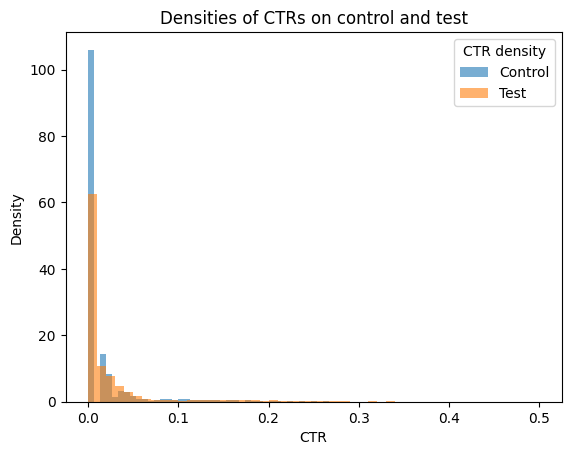

In [33]:
plt.hist(control.ctr, density=True, bins=50, label='Control', alpha=0.6)
plt.hist(test.ctr, density=True, bins=50, label='Test', alpha=0.6)
plt.legend(title="CTR density")
plt.title("Densities of CTRs on control and test")
plt.xlabel("CTR")
plt.ylabel("Density")
plt.show()

Уже видим, что на тесте CTR стал выглядеть лучше в плане распределения - на контроле видим очень много людей с околонулевым CTR, тогда как на тесте CTR выше какой-то нулевой отметки у большего числа людей + выбросы с точки зрения большого CTR видно только на тесте

In [34]:
print("P-value is:", stats.mannwhitneyu(control.ctr, test.ctr).pvalue)

P-value is: 1.1303345064750247e-37


Видим, что есть статзначимость $\implies$ есть различия в матожиданиях $\implies$ эксперимент изменяет итоговый CTR (растёт, как мы видим из графиков и среднего CTR)

Сделаем тест с бакетизацией (возьмем кол-во бинов, равное 100):

In [35]:
control['bucket'] = pd.cut(control.ctr, bins=100, retbins=True, labels=range(100))[0]
test['bucket'] = pd.cut(test.ctr, bins=100, retbins=True, labels=range(100))[0]

<ipython-input-35-11b514e104dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control['bucket'] = pd.cut(control.ctr, bins=100, retbins=True, labels=range(100))[0]
<ipython-input-35-11b514e104dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['bucket'] = pd.cut(test.ctr, bins=100, retbins=True, labels=range(100))[0]


Визуализируем бины:

<ipython-input-43-fb9aed67ccda>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.hist(control.groupby('bucket').mean()['ctr'], bins=25, density=True)


(array([2.14285714, 4.28571429, 4.28571429, 4.28571429, 4.28571429,
        4.28571429, 4.28571429, 4.28571429, 4.28571429, 4.28571429,
        3.21428571, 3.21428571, 3.21428571, 4.28571429, 2.14285714,
        3.21428571, 4.28571429, 4.28571429, 2.14285714, 1.07142857,
        2.14285714, 0.        , 0.        , 0.        , 1.07142857]),
 array([0.        , 0.01333333, 0.02666667, 0.04      , 0.05333333,
        0.06666667, 0.08      , 0.09333333, 0.10666667, 0.12      ,
        0.13333333, 0.14666667, 0.16      , 0.17333333, 0.18666667,
        0.2       , 0.21333333, 0.22666667, 0.24      , 0.25333333,
        0.26666667, 0.28      , 0.29333333, 0.30666667, 0.32      ,
        0.33333333]),
 <BarContainer object of 25 artists>)

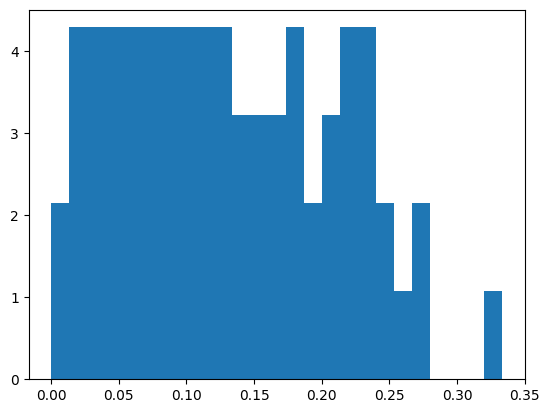

In [43]:
plt.hist(control.groupby('bucket').mean()['ctr'], bins=25, density=True)

<ipython-input-44-03209fd6532f>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.hist(test.groupby('bucket').mean()['ctr'], bins=25, density=True)


(array([2.17391304, 2.89855072, 2.89855072, 2.89855072, 2.89855072,
        2.89855072, 2.89855072, 2.89855072, 2.89855072, 2.17391304,
        2.89855072, 2.89855072, 2.17391304, 2.89855072, 2.17391304,
        2.17391304, 0.72463768, 0.        , 2.17391304, 0.72463768,
        1.44927536, 0.        , 1.44927536, 0.        , 0.72463768]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 ]),
 <BarContainer object of 25 artists>)

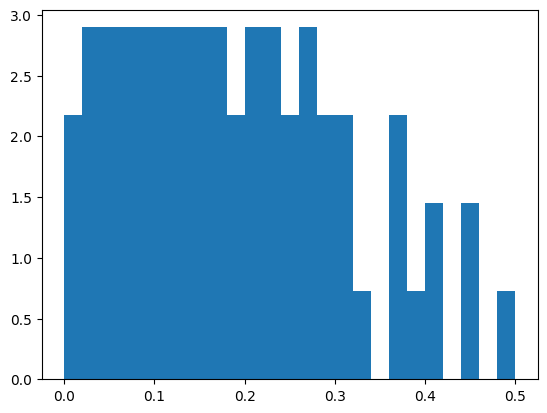

In [44]:
plt.hist(test.groupby('bucket').mean()['ctr'], bins=25, density=True)

In [45]:
control_ctr_buckets = control[['bucket', 'ctr']].groupby('bucket').mean()['ctr'].dropna()
test_ctr_buckets = test[['bucket', 'ctr']].groupby('bucket').mean()['ctr'].dropna()

Теперь проверим t-тестом гипотезу на бакетизированных данных:

In [46]:
print("P-value on bucketized data is:", stats.ttest_ind(control_ctr_buckets, test_ctr_buckets).pvalue)

P-value on bucketized data is: 0.0006987322135101129


Результат (гипотеза отвергается) совпадает с изначальным тестом.

Сделаем тест, используя дельта метод (т.к. мы имеем дело с проверкой гипотезы на отношении двух метрик):

In [47]:
def delta_method_var(x, y, cov_xy, n):
    y_mean = y.mean()
    x_mean = x.mean()
    y_var = y.var(ddof=1)
    x_var = x.var(ddof=1)
    return 1. / n * (x_var / y_mean ** 3 - 2 * cov_xy * x_mean / y_mean ** 3 + y_var * x_mean ** 2 / y_mean ** 4)

In [48]:
delta_var_control = delta_method_var(control.clicks,
                                     control.views,
                                     control.cov()['views']['clicks'],
                                     control.shape[0])
delta_var_test = delta_method_var(test.clicks,
                                  test.views,
                                  test.cov()['views']['clicks'],
                                  test.shape[0])

<ipython-input-48-e2b8761a6696>:3: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  control.cov()['views']['clicks'],
<ipython-input-48-e2b8761a6696>:7: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  test.cov()['views']['clicks'],


In [49]:
delta_var_control, delta_var_test

(2.543809590968728e-09, 2.3964039093297086e-09)

In [50]:
t_stat = np.abs((control.ctr.mean() - test.ctr.mean()) / np.sqrt(delta_var_control + delta_var_test))

In [52]:
print("P-value for delta method test is:", stats.norm.sf(t_stat)) # можем использовать нормальное стандартное, т.к. в обеих выборках достаточно данных, чтобы аппроксимировать Стьюдента нормальным

P-value for delta method test is: 0.0


Результат (гипотеза отвергается) совпадает с изначальным тестом.

Имеем, что результаты теста с уточнением совпадает с изначальным тестом Манна-Уитни.

## bootstrap (3 балла)

Ещё раз подведите итоги проведённого А/В теста, используя [бутстрэп](https://habr.com/ru/companies/X5Tech/articles/679842/)

1. Оцените разницу в метриках, используя наивный бутстрэп и прокомментируйте, изменился ли результат А/В теста (1 балл)
2. Оцените разницу в метриках, используя t-бутстрэп и прокомментируйте, изменился ли результат А/В теста (1 балл)
3. Оцените разницу в метриках, используя BCA бутстрэп и прокомментируйте, изменился ли результат А/В теста (1 балл)

Т.к. у нас в тесте и в контроле одинаковое кол-во наблюдений, то можем вычесть CTR контроля и теста, построить 95% доверительные интервалы для среднего у CTR и проверить, что 0 не лежит в этом доверительном интервале (это будет говорить о том, что мы можем гарантировать с нужным уровнем значимости то, что среднее разницы равна нулю (ввиду линейности матожидания это то же самое, что и разница средних))

In [53]:
ctr_differencies = control.ctr.values - test.ctr.values

1. Наивный бутстрэп:

In [54]:
ctr_differencies

array([-0.0271105 ,  0.        , -0.03571429, ..., -0.0212766 ,
       -0.22727273,  0.        ])

In [55]:
B = 10000
ALPHA = 0.95

In [56]:
bootstrapped = np.random.choice(ctr_differencies, (ctr_differencies.shape[0], B), replace=True)
means = np.sort(np.mean(bootstrapped, axis=0))
conf_interval = (means[int(((1 - ALPHA) / 2 * means.shape[0]) // 1)],
                       means[int(((1 + ALPHA) / 2 * means.shape[0]) // 1)])

In [57]:
print(f"Our {(1 - ALPHA):2f}-confidence interval is", conf_interval)

Our 0.050000-confidence interval is (-0.00856740505548521, -0.006127264820661429)


Видим, что 0 не лежит в доверительном интервале наивного бутстрэпа $\implies$ есть статзначимая разница, при этом среднее меньше нуля $\implies$ среднее CTR на тесте больше среднего на контроле

2. T-бутстрэп:

In [58]:
ctr_diff_mean = ctr_differencies.mean()
bootstrap_samples = np.random.choice(ctr_differencies, size=(ctr_differencies.shape[0], B), replace=True)
bootstrap_means = np.mean(bootstrap_samples, axis=0)
bootstrap_ses = []

for i in range(bootstrap_samples.shape[1]):
  bootstrap_subsamples = np.random.choice(bootstrap_samples[:, i], size=(ctr_differencies.shape[0], int(np.sqrt(B))), replace=True)
  bootstrap_subsamples_mean = np.mean(bootstrap_subsamples, axis = 0)
  bootstrap_ses.append(np.std(bootstrap_subsamples_mean))
bootstrap_ses = np.array(bootstrap_ses)

T = (bootstrap_means - ctr_diff_mean) / bootstrap_ses
T_quantiles = np.quantile(T, ((1 - ALPHA) / 2, (1 + ALPHA) / 2))

bootstrap_std = np.std(bootstrap_means)

LB = ctr_diff_mean - T_quantiles[1] * bootstrap_std
UB = ctr_diff_mean - T_quantiles[0] * bootstrap_std
print(f"Our {(1 - ALPHA):2f}-confidence interval is ({LB}, {UB})")

Our 0.050000-confidence interval is (-0.008574332576182273, -0.006122114340183291)


Видим, что 0 не лежит в доверительном интервале t-бутстрэпа $\implies$ есть статзначимая разница, при этом среднее меньше нуля $\implies$ среднее CTR на тесте больше среднего на контроле

3. BCA-бутстрэп:

In [59]:
res = stats.bootstrap((ctr_differencies, ), np.mean, confidence_level=ALPHA, method='BCa')
print(f"Our {(1 - ALPHA):2f}-confidence interval is ({res.confidence_interval.low}, {res.confidence_interval.high})")

Our 0.050000-confidence interval is (-0.008562747674425577, -0.006155902398034842)


Видим, что 0 не лежит в доверительном интервале BCA-бутстрэпа $\implies$ есть статзначимая разница, при этом среднее меньше нуля $\implies$ среднее CTR на тесте больше среднего на контроле

Итого - видим, что все три метода бутстрэпа дают тот же вердикт (гипотеза отвергается), что и методы проверки, которые мы использовали выше (Манн-Уитни, дельта-метод, ...).

При этом важно, что мы увидели и знак среднего разниц метрик в случае бутстрапа, тогда как в традиционных методах проверки гипотез мы только можем выяснить, совпадают ли у нас средние CTR в тесте и контроле или нет, и в случае традиционных гипотез нам требовались дополнительные действия, которые могут быть менее релевантными (типа посмотреть на график или посчитать просто средние метрик на тесте и контроле).

## Выводы (1.5 балла)

In [60]:
print(f'The boost of CTR shown during experiment: {((np.mean(test.ctr) / np.mean(control.ctr) - 1) * 100):3f}%')

The boost of CTR shown during experiment: 48.430044%


Содержательные выводы по итогам работы, интерпретирующие результат с бизнесовой точки зрения, как минимум 3-4 предложения

**NOTE:** если вы неверно выберете фичу сплитования или интерпретация полученных результатов А/В окажется некорректной, то за этот пункт будет поставлено 0 баллов вне зависимости от объёма выводов

*YOUR TEXT IS HERE*

P.S. считаем, что у нас та же затравка, как и в 11 семинаре про A/B тест - мы рекламная платформа, и мы проверяем, принесёт ли изменение модели машинного обучения (логрег заменим на catboost) в сервисе ранжирования рекламных объявлений бОльшую конверсию просмотров объявления в клик



Видим, что фича, которую мы собираемся выкатывать, повышает средний CTR рекламных объявлений на ~48%. Факт того, что средний CTR с новой фичей повышается, подтверждается несколькими независимыми проверками гипотез, что говорит о том, что новая фича действительно принесла бОльшую конверсию просмотров объявления в клик, и это не случайный "прокрас".

С точки зрения бизнеса, это означает, что мы показываем более релевантную пользователям рекламу - значит, мы больше можем зарабатывать на рекламодателях, которые платят нам за каждый клик на рекламное объявление. Мало того, за счёт более лучшей конверсии просмотров объявления в клик мы можем предлагать рекламодателям более гибкие тарифы оплаты за рекламу на нашей платформе (к примеру, брать n рублей в месяц за достижение k% конверсии в клик), а также показывать пользователям рекламу, которая им лучше приглянется, что повысит репутацию нашего сервиса.

## Бонус: CUPED (1 балл)

Опишите понятным проверяющему языком, каким образом работает CUPED и реализуйте его для проведённого А/В теста

Смысл CUPED - мы можем сделать наши эксперименты более чувствительными к экспериментам, если у нас есть данные до эксперимента.

Идея - мы фиттим линейную регрессию вида $Y = \theta (X - \mathbb{E}X) + \hat{Y}$, в которой мы можем явно записать $\theta$:

$$\theta = \frac{cov(X, Y)}{var(X)}$$

Тогда нашей CUPED-метрикой будет $\hat{Y}$ из формулы выше, которая считается как

$$\hat{Y} = Y - \theta(X - \mathbb{E}X), \theta = \frac{cov(X, Y)}{var(X)}$$

За счёт того, что мы пытаемся объяснить часть "дисперсии" итоговых метрик историческими, мы получаем, что дисперсия CUPED-метрики снижатется. Интересное наблюдение: самое лучшее X - историческая метрика, на которой проверяется A/B тест (метрика до эксперимента).

Т.к. исторических наблюдений по CTR у нас нет, то в качестве X мы можем взять имеющиеся у нас признаки - посмотрим на $\theta$ у этих признаков, и в качестве итогового X возьмём признак, который максимально снизит итоговый CTR.

In [61]:
def cuped_estimate(x, y, cov_xy):
    return y - cov_xy / x.var() * (x - x.mean())

In [62]:
print("Variance before CUPED:", data['ctr'].var())
print("Variance after CUPED on is_teenager:", cuped_estimate(data['is_teenager'], data['ctr'], data.cov()['ctr']['is_teenager']).var())
print("Variance after CUPED on num_segments:", cuped_estimate(data['num_segments'], data['ctr'], data.cov()['ctr']['num_segments']).var());

Variance before CUPED: 0.0019135370957491366
Variance after CUPED on is_teenager: 0.001786785112936489
Variance after CUPED on num_segments: 0.0019122696655000135


<ipython-input-62-f4129962dd76>:2: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print("Variance after CUPED on is_teenager:", cuped_estimate(data['is_teenager'], data['ctr'], data.cov()['ctr']['is_teenager']).var())
<ipython-input-62-f4129962dd76>:3: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print("Variance after CUPED on num_segments:", cuped_estimate(data['num_segments'], data['ctr'], data.cov()['ctr']['num_segments']).var());


Видим, что CUPED-метрика, построенная по is_teenager, лучше уменьшила дисперсию метрики, по которой мы оцениваем эксперимент.


In [63]:
data['cuped'] = cuped_estimate(data['is_teenager'], data['ctr'], data.cov()['ctr']['is_teenager'])
control['cuped'] = data[data['split_2'] == 'A']['cuped']
test['cuped'] = data[data['split_2'] == 'B']['cuped']

<ipython-input-63-3a43b8f8bae2>:1: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data['cuped'] = cuped_estimate(data['is_teenager'], data['ctr'], data.cov()['ctr']['is_teenager'])
<ipython-input-63-3a43b8f8bae2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control['cuped'] = data[data['split_2'] == 'A']['cuped']
<ipython-input-63-3a43b8f8bae2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

Проведём ещё раз тест Манна-Уитни и посмотрим на p-value:

In [64]:
print("P-value is:", stats.mannwhitneyu(control.cuped, test.cuped).pvalue)

P-value is: 2.657647910490425e-29


In [65]:
cuped_differencies = control.cuped.values - test.cuped.values
res_cuped = stats.bootstrap((cuped_differencies, ), np.mean, confidence_level=ALPHA, method='BCa')
res = stats.bootstrap((ctr_differencies, ), np.mean, confidence_level=ALPHA, method='BCa')
print(f"Our {(1 - ALPHA):2f}-confidence interval for CUPED is ({res_cuped.confidence_interval.low}, {res_cuped.confidence_interval.high}), interval length is {res_cuped.confidence_interval.high - res_cuped.confidence_interval.low}")
print(f"Our {(1 - ALPHA):2f}-confidence interval is ({res.confidence_interval.low}, {res.confidence_interval.high}), interval length is {res.confidence_interval.high - res.confidence_interval.low}")

Our 0.050000-confidence interval for CUPED is (-0.00861386699322202, -0.006294220108063926), interval length is 0.0023196468851580934
Our 0.050000-confidence interval is (-0.008559574220632053, -0.006126814856131628), interval length is 0.002432759364500425


Видим, что для CUPED-метрики доверительный интервал сократился на целую одну десятитысячную!!!